In [2]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, BatchNormalization
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

## Utility

In [12]:
class DDPGProcessor(WhiteningNormalizerProcessor):
    def process_action(self, actions):
        return np.random.choice([0,1], p=actions)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if self.training and np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super(CustomDDPGAgent, self).select_action(state)
        


## Different Configurations

In [3]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=20)
obs_shape = (20, 2)
env = env_creator()
nb_actions = env.action_space.n

def actorModel():
    model = Sequential()
    model.add(Conv2D(input_shape=(1,) + obs_shape, filters=32, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
#actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
    x = Conv2D(filters=32, kernel_size=(4,2), padding='same', activation='relu')(observation_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(4,2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    flattened_observation = Flatten()(x)
    
    #flattened_observation = Flatten()(observation_input)
    y = Concatenate()([action_input, flattened_observation])
    y = Dense(512)(y)
    y = Activation('relu')(y)
    y = Dense(256)(y)
    y = Activation('relu')(y)
    y = Dense(1)(y)
    output = Activation('linear')(y)
    critic = Model(inputs=[action_input, observation_input], outputs=output)
    #print("critic")
    #critic.summary()
    return critic, action_input
#criticModel()[0].summary()
def agent_creator():
    memory = SequentialMemory(limit=2048, window_length=1)
    processor = DDPGProcessor()
    
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

In [10]:
from evaluator import Evaluator

#e = Evaluator(agent_creator, env_creator, name="ddpg")
#e.train(repeat=1)


In [11]:
#e.process_train_result()
#e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=20))

In [ ]:
class DDPGProcessor(WhiteningNormalizerProcessor):
    def process_action(self, actions):
        return np.random.choice([0,1], p=actions)

In [13]:
from data import EURUSD_HOUR
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'AskClose'].to_numpy()[start:end]
    
    signal_features = env.df.loc[:, ['AskOpen','AskHigh','AskLow','AskClose','AskChange']].to_numpy()[start:end]
    diffs = np.diff(signal_features, axis=0)
    diffs = np.insert(diffs, 0, np.zeros(diffs.shape[1]), axis=0)
    signal_features = np.column_stack((signal_features, diffs))
    
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data

def env_creator():
    return MyForexEnv(df=EURUSD_HOUR, window_size=30, frame_bound=(50, 80000))
env = env_creator()
obs_shape = env.reset().shape
print("max possible profit: {}".format(env.max_possible_profit()))
def actorModel():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + obs_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model
#actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,) + obs_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    
    #flattened_observation = Flatten()(observation_input)
    y = Concatenate()([action_input, flattened_observation])
    y = Dense(1024)(y)
    y = Activation('relu')(y)
    y = Dense(1024)(y)
    y = Activation('relu')(y)
    y = Dense(1024)(y)
    y = Activation('relu')(y)
    y = Dense(1)(y)
    output = Activation('linear')(y)
    critic = Model(inputs=[action_input, observation_input], outputs=output)
    #print("critic")
    #critic.summary()
    return critic, action_input
#criticModel()[0].summary()
def agent_creator():
    memory = SequentialMemory(limit=2048, window_length=1)
    processor = DDPGProcessor()
    
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=1e-3)
    agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])
    return agent

max possible profit: 2485856055592.9863


Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
  156/15989 [..............................] - ETA: 1:18 - reward: -8.4872 - cumulative_reward: -978.0321WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
15989/15989 [==============================] - 464s 29ms/step - reward: 0.4361 - cumulative_reward: 1535.7909
train 1 completed. took 467.065 seconds, total_reward: 6973.900000000197 total_profit: 0.3097919028519685
min reward: -527.9999999999995, max reward: 660.0000000000006, mean_reward: 0.08722935871618404


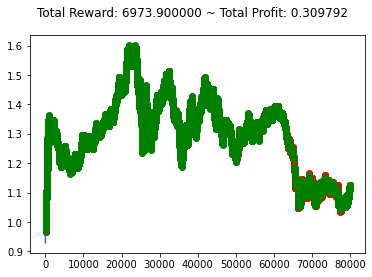

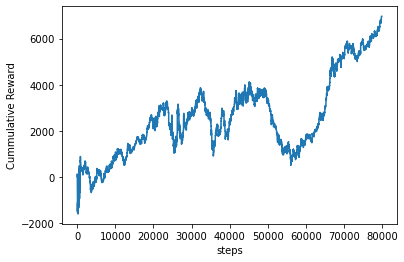

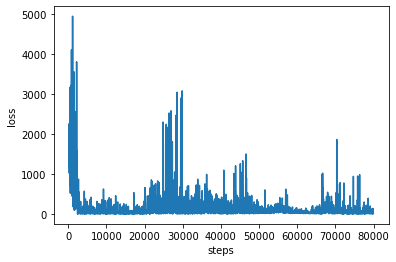

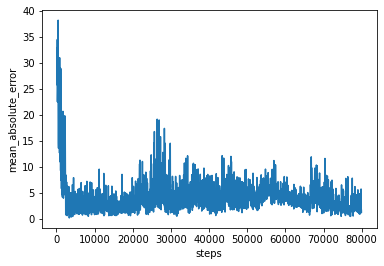

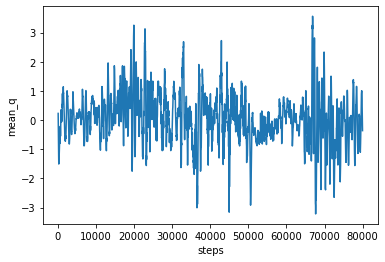

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 460s 29ms/step - reward: 0.1792 - cumulative_reward: 285.8567
train 2 completed. took 933.410 seconds, total_reward: 2864.8999999999046 total_profit: 0.266365265486716
min reward: -600.0000000000006, max reward: 894.9999999999991, mean_reward: 0.035834094235073666


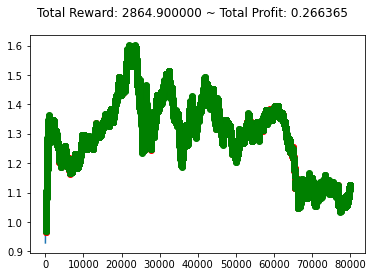

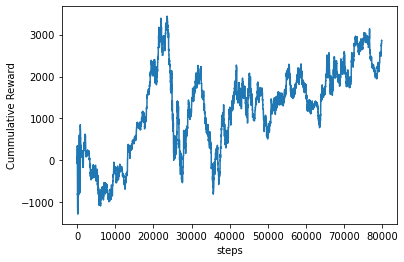

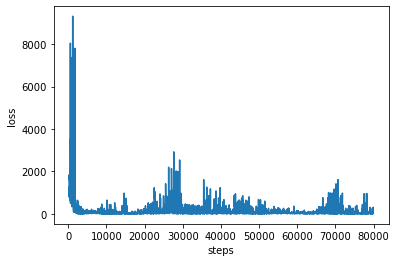

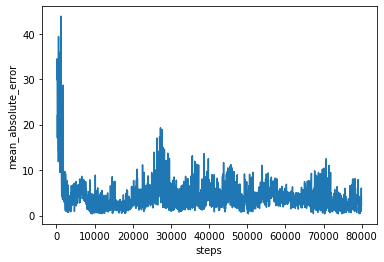

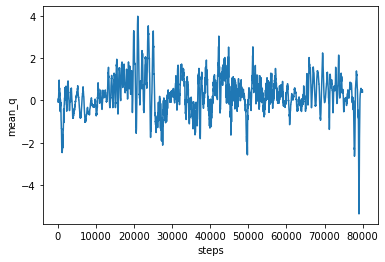

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 512s 32ms/step - reward: -0.1871 - cumulative_reward: -3994.3796
train 3 completed. took 1451.532 seconds, total_reward: -2992.1000000000017 total_profit: 0.28381903478913384
min reward: -936.999999999999, max reward: 562.1000000000009, mean_reward: -0.03742510850667303


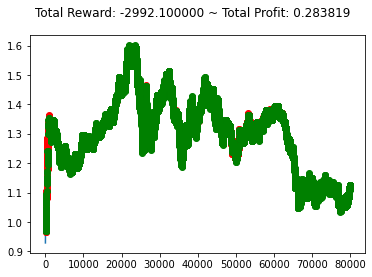

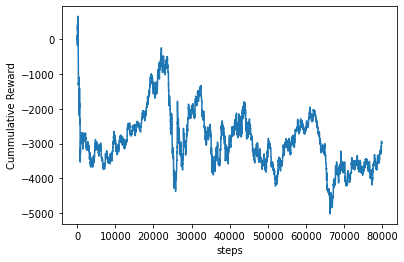

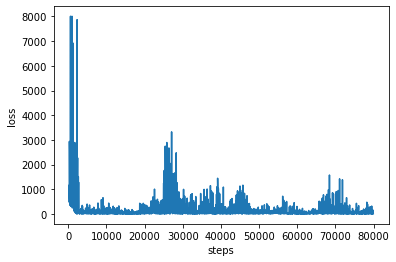

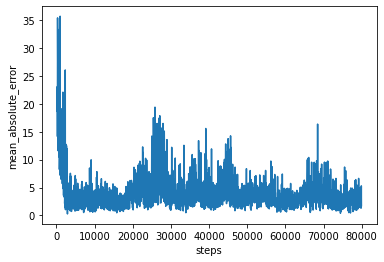

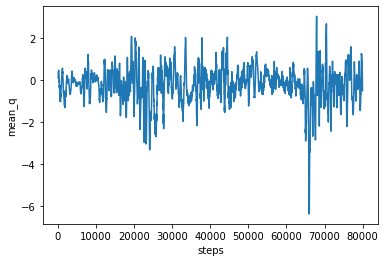

In [14]:
e = Evaluator(agent_creator, env_creator, name="ddpg-90k")
e.train(repeat=3)

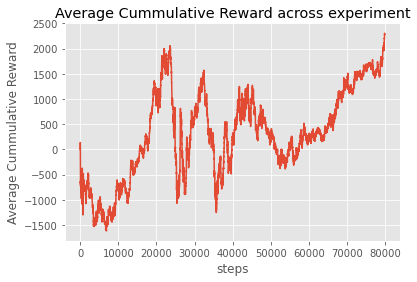

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 20s 10ms/step - reward: 0.2938 - cumulative_reward: 334.7392
Episode 1: reward: 587.500, steps: 9999
test completed. total_reward: 587.5000000000074 total_profit: 0.9807794951493446
min reward: -150.89999999999827, max reward: 290.2999999999989, mean_reward: 0.05875587558755949


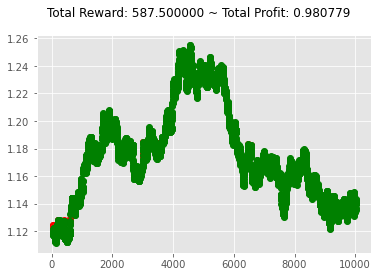

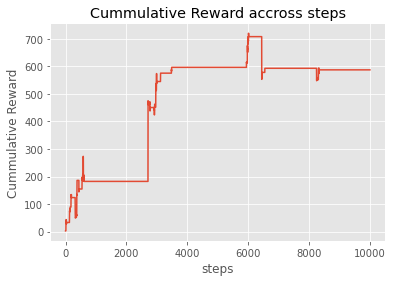

In [15]:
e.process_train_result()
e.test(MyForexEnv(df=EURUSD_HOUR, window_size=30, frame_bound=(80000, 90000)))